# <font style="color:blue">Part 1: Data Understanding & Pipeline Check</font>


# <font style="color:blue">Understanding the Problem </font><a name="step1"></a>


## <font style="color:blue">Fetch the Data</font>

### <a target="_blank" href="https://www.kaggle.com/t/288960a266a34e52a968037d0951bac3">Link</a> to the Data Tab.



In [1]:
import os
import matplotlib.pyplot as plt


# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

## <font style="color:blue">Explore the Data</font><a name="step2b"></a>


In [2]:
root_dir = r"/kaggle/input/opencv-pytorch-project-1-classification/dataset"

train_dir = os.path.join(root_dir, "Train")
valid_dir = os.path.join(root_dir, "Valid")

### <font style="color:green">Folder Structure </font>


In [3]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * (level)
        print(f"{indent}{os.path.basename(root):<8}")


list_folders(root_dir)

dataset 
    Valid   
        dog     
        panda   
        cat     
    Test    
    Train   
        dog     
        panda   
        cat     


### <font style="color:green">Import the Datasets Module</font>

Load the data utilizing the `datasets` module.

In [4]:
from torchvision import datasets

### <font style="color:green">Create a Dataset Object </font>


In [5]:
train_data = datasets.ImageFolder(train_dir)
validation_data = datasets.ImageFolder(valid_dir)

### <font style="color:green">List the Classes</font>

It simply prints the sub folders present under the training or validation folder.


In [6]:
print(train_data.classes)
print(validation_data.classes)

['cat', 'dog', 'panda']
['cat', 'dog', 'panda']


### <font style="color:green">Get the Class ID to Name Mapping</font>

In [7]:
print(train_data.class_to_idx)
print(validation_data.class_to_idx)

{'cat': 0, 'dog': 1, 'panda': 2}
{'cat': 0, 'dog': 1, 'panda': 2}


### <font style="color:green">Number of Samples in Training and Validation Folders</font>


In [8]:
print(f"Number of samples in Train class: {train_data.__len__()}")
print(f"Number of samples in Validation class: {validation_data.__len__()}")

Number of samples in Train class: 2100
Number of samples in Validation class: 300


### <font style="color:green">Display Some Samples</font>

Display one sample from each class. 
The train dataset contains

- cats from 0 to 699
- dogs from 700 to 1399
- pandas from 1400 to 2099

image size: (154, 110), target: 0


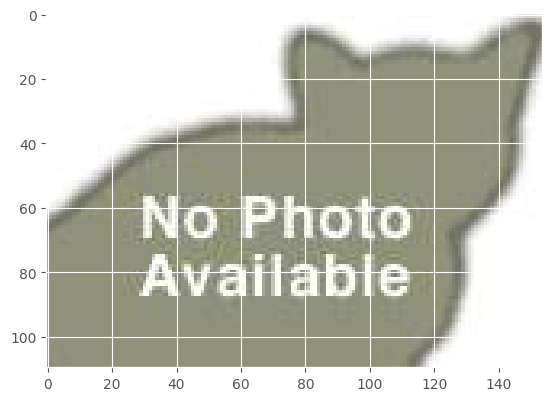

In [9]:
from random import randint
random_kat = randint(0, 699)
img, target = train_data[random_kat]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

image size: (447, 500), target: 1


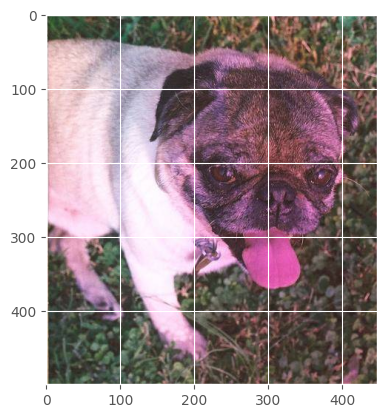

In [10]:
random_dog = randint(700, 1399)
img, target = train_data[random_dog]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

image size: (375, 500), target: 2


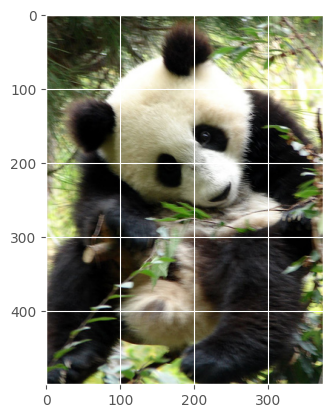

In [11]:
random_panda = randint(1400, 2099)
img, target = train_data[random_panda]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

**Note:** The images are all of different size.


## <font style="color:blue">Create Sample Data</font><a name="step2c"></a>

Take `5%` images from training and validation to create a small sample dataset, which will check our training pipeline.


In [12]:
import torch
import numpy as np

In [13]:
subset_size = 0.05

### <font style="color:green">Create a Subset From the Original Data</font>

Instead of copying the original data, use the `Subset` method in `torch` to create a subset of the data. And use this to train the model.

In [14]:
train_subset = torch.utils.data.Subset(train_data, np.arange(0, len(train_data), 1.0 / subset_size))

validation_subset = torch.utils.data.Subset(validation_data, np.arange(0, len(validation_data), 1.0 / subset_size))

In [15]:
train_subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=8, num_workers=1, shuffle=False)

validation_subset_loader = torch.utils.data.DataLoader(validation_subset, batch_size=8, num_workers=1, shuffle=False)

In [16]:
print("Train Subset Size: {}".format(len(train_subset_loader.dataset)))
print("Validation Subset Size: {}".format(len(validation_subset_loader.dataset)))

Train Subset Size: 105
Validation Subset Size: 15


A separate function called `subset_data_loader` to create data loaders for subsets.


# <font style="color:blue">Data Preparation</font> <a name="step3"></a>

Now that we have seen how the data is organized, time to configure the train and valid loaders to feed the training pipeline.


## <font style="color:blue">Import Libraries </font>


In [17]:
import time
from dataclasses import dataclass
from typing import List, Union, Tuple


from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

2024-07-03 20:31:58.020212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 20:31:58.020327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 20:31:58.147037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## <font style="color:blue">Image Transforms</font>

Normalize the data. Some of the standard ways of doing it is to, subtract the mean, make all images equal in size or to rescale the range to `[0., 1.]` etc.


### <font style="color:green">Compulsary Preprocessing Transforms</font>


In [18]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess

### <font style="color:green">Common Image Transforms</font>

Normalize using mean and std. More transforms can be added here.


In [19]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

### <font style="color:green">Mean and STD</font>


In [20]:
def get_mean_std(data_root, img_size=(224, 224), num_workers=4):
    transform = image_preprocess_transforms(img_size=img_size)

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

### <font style="color:green">Augmented Image Transforms</font>

In [21]:
def image_augmented_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):

    augmented_transforms = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.RandomResizedCrop(size=img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=(-0.1, 0.1), translate=(0.1, 0.1), scale=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

    return augmented_transforms

## <font style="color:blue">Data Loaders </font>


### <font style="color:green">Data Loader for Full Data</font>

Data loader is used by the training routine to generate batches of data:


In [22]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )

    return loader

### <font style="color:green">Data Loader for Subset</font>

Data loader which uses the `Subset` to generate batches


In [23]:
def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    data_subset = torch.utils.data.Subset(
        dataset,
        np.arange(0, len(dataset), 1.0 / subset_size).astype(int),
    )

    loader = torch.utils.data.DataLoader(data_subset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return loader

## <font style="color:blue">Prepare Data</font>

The main function which uses all the above functions to generate the train and valid dataloaders.


In [24]:
def get_data(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")

    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)

    common_transforms = image_common_transforms(img_size, mean, std)

    # If data_augmentation is true data augmentation will be applied.
    if data_augmentation:
        train_transforms = image_augmented_transforms(img_size, mean, std)
    # Else simply do common transforms
    else:
        train_transforms = common_transforms

    # Train dataloader
    train_loader = subset_data_loader(
        train_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    # Valid dataloader
    valid_data_path = os.path.join(data_root, "Valid")

    valid_loader = subset_data_loader(
        valid_data_path,
        common_transforms, # Only common transforms apply to valid set
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader

# <font style="color:blue">Train a Simple Model</font><a name="step4"></a>

Creating the training pipeline and training a simple model on our sample data.

## <font style="color:blue">Configurations</font>

Defining the training and system configurations. 


### <font style="color:green">System Configuration</font>


In [25]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 21  # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # Enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # Make cudnn deterministic (reproducible training)

### <font style="color:green">Training Configuration</font>


In [26]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 3
    batch_size: int = 4 # Batch size to 4
    img_size: Tuple = (224, 224)
    epochs_count: int = 100 # Epochs to 100
    init_learning_rate: float = 0.0001  # Initial learning rate
    data_root: str = "/kaggle/input/opencv-pytorch-project-1-classification/dataset"
    num_workers: int = 2
    device: str = "cuda"

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "cat_dog_panda_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

### <font style="color:green">System Setup</font>


In [27]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">Training Function</font>


In [28]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    
    # Change model in training mode.
    model.train()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(train_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Batch Loss.
        mean_metric(loss.item(), weight=data.shape[0])

        # # Get probability score using softmax.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Train Loss: {mean_metric.compute():.4f}, Train Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = mean_metric.compute()
    epoch_acc = acc_metric.compute()

    prog_bar.close()

    return epoch_loss, epoch_acc

## <font style="color:blue">Validation Function</font>


In [29]:
def validate(
    train_config: TrainingConfig, 
    model: nn.Module, 
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int, 
    total_epochs: int
) -> Tuple[float, float]:

    # Change model in evaluation mode.
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(valid_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        valid_loss = F.cross_entropy(output, target).item()

        # Batch validation loss.
        mean_metric(valid_loss, weight=data.shape[0])

        # # Convert model's logits to probability scores.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Valid Loss: {mean_metric.compute():.4f}, Valid Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    valid_loss = mean_metric.compute()
    valid_acc = acc_metric.compute()

    prog_bar.close()

    return valid_loss, valid_acc

## <font style="color:blue">Save & Load Model</font>


In [30]:
def save_model(model, device, model_dir="models", model_file_name="cat_dog_panda_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [31]:
def load_model(model, model_dir="models", model_file_name="cat_dog_panda_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

## <font style="color:blue">Logging Setup</font>

This function will be initializing directories so that they save tensorboard and model checkpoints for different training versions.


In [32]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

## <font style="color:blue">Plot Loss and Accuracy</font>


In [33]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

## <font style="color:blue">Main Function for Training</font>

Creating a cohesive and streamlined workflow.

In [34]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):
    
    # Setup system configuration.
    setup_system(system_config)

    # Initialize data loader
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
    )

    # Number of epochs to train.
    NUM_EPOCHS = training_config.epochs_count

    # Set acceleration device.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Send model to device (GPU/CPU)
    model.to(device)

    # Initialize Adam optimizer.
    optimizer = optim.Adam(model.parameters(), lr=training_config.init_learning_rate)

    best_loss = torch.tensor(np.inf)

    # Epoch train & valid loss accumulator.
    epoch_train_loss = []
    epoch_valid_loss = []

    # Epoch train & valid accuracy accumulator.
    epoch_train_acc = []
    epoch_valid_acc = []

    # Trainig time measurement
    t_begin = time.time()

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(training_config, model, optimizer, train_loader, epoch + 1, NUM_EPOCHS)
        val_loss, val_accuracy = validate(training_config, model, valid_loader, epoch + 1, NUM_EPOCHS)

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_valid_loss.append(val_loss)
        epoch_valid_acc.append(val_accuracy)

        summary_writer.add_scalar("Loss/Train", train_loss, epoch)
        summary_writer.add_scalar("Accuracy/Train", train_acc, epoch)

        summary_writer.add_scalar("Loss/Validation", val_loss, epoch)
        summary_writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            torch.save(model.state_dict(), os.path.join(training_config.checkpoint_dir, training_config.save_model_name))
            print("Done.\n")

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

## <font style="color:blue">Define Model</font>


In [35]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        # Fully connected layers
        self._head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 52 * 52, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=3),
        )

    def forward(self, x):
        # Apply feature extractor
        x = self._body(x)

        # Apply classification head
        x = self._head(x)

        return x

## <font style="color:blue">Training</font>


In [36]:
model = MyModel()
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=173056, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=3, bias=True)
  )
)
Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0


In [37]:
# Train and Validate
train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    scheduler=None,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


Train:	Epoch: 1/100 Train Loss: 1.2121, Train Acc: 0.3619: 100%|██████████| 27/27 [00:01<00:00, 15.42it/s]
Valid:	Epoch: 1/100 Valid Loss: 1.2464, Valid Acc: 0.1333: 100%|██████████| 4/4 [00:00<00:00, 20.41it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/100 Train Loss: 0.6502, Train Acc: 0.8095: 100%|██████████| 27/27 [00:00<00:00, 39.99it/s]
Valid:	Epoch: 2/100 Valid Loss: 1.7268, Valid Acc: 0.0667: 100%|██████████| 4/4 [00:00<00:00, 25.74it/s]


Train:	Epoch: 3/100 Train Loss: 0.3124, Train Acc: 0.8857: 100%|██████████| 27/27 [00:00<00:00, 39.38it/s]
Valid:	Epoch: 3/100 Valid Loss: 1.3774, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.65it/s]


Train:	Epoch: 4/100 Train Loss: 0.1026, Train Acc: 0.9905: 100%|██████████| 27/27 [00:00<00:00, 39.15it/s]
Valid:	Epoch: 4/100 Valid Loss: 1.8327, Valid Acc: 0.2000: 100%|██████████| 4/4 [00:00<00:00, 24.23it/s]


Train:	Epoch: 5/100 Train Loss: 0.0260, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.09it/s]
Valid:	Epoch: 5/100 Valid Loss: 2.0685, Valid Acc: 0.2000: 100%|██████████| 4/4 [00:00<00:00, 25.89it/s]


Train:	Epoch: 6/100 Train Loss: 0.0113, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.02it/s]
Valid:	Epoch: 6/100 Valid Loss: 2.1139, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.16it/s]


Train:	Epoch: 7/100 Train Loss: 0.0076, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.08it/s]
Valid:	Epoch: 7/100 Valid Loss: 2.2323, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 26.60it/s]


Train:	Epoch: 8/100 Train Loss: 0.0032, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.01it/s]
Valid:	Epoch: 8/100 Valid Loss: 2.3428, Valid Acc: 0.2000: 100%|██████████| 4/4 [00:00<00:00, 25.57it/s]


Train:	Epoch: 9/100 Train Loss: 0.0022, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 36.36it/s]
Valid:	Epoch: 9/100 Valid Loss: 2.3490, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 25.88it/s]


Train:	Epoch: 10/100 Train Loss: 0.0017, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.52it/s]
Valid:	Epoch: 10/100 Valid Loss: 2.4048, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 28.27it/s]


Train:	Epoch: 11/100 Train Loss: 0.0014, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.04it/s]
Valid:	Epoch: 11/100 Valid Loss: 2.4272, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 25.41it/s]


Train:	Epoch: 12/100 Train Loss: 0.0012, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.66it/s]
Valid:	Epoch: 12/100 Valid Loss: 2.4659, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.69it/s]


Train:	Epoch: 13/100 Train Loss: 0.0010, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.06it/s]
Valid:	Epoch: 13/100 Valid Loss: 2.4989, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 25.86it/s]


Train:	Epoch: 14/100 Train Loss: 0.0009, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 37.61it/s]
Valid:	Epoch: 14/100 Valid Loss: 2.5138, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 22.41it/s]


Train:	Epoch: 15/100 Train Loss: 0.0008, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 35.81it/s]
Valid:	Epoch: 15/100 Valid Loss: 2.5244, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 24.65it/s]


Train:	Epoch: 16/100 Train Loss: 0.0007, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.66it/s]
Valid:	Epoch: 16/100 Valid Loss: 2.5738, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.73it/s]


Train:	Epoch: 17/100 Train Loss: 0.0006, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.15it/s]
Valid:	Epoch: 17/100 Valid Loss: 2.5904, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.69it/s]


Train:	Epoch: 18/100 Train Loss: 0.0005, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.95it/s]
Valid:	Epoch: 18/100 Valid Loss: 2.6199, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.31it/s]


Train:	Epoch: 19/100 Train Loss: 0.0005, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.65it/s]
Valid:	Epoch: 19/100 Valid Loss: 2.6315, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 29.88it/s]


Train:	Epoch: 20/100 Train Loss: 0.0004, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.00it/s]
Valid:	Epoch: 20/100 Valid Loss: 2.6646, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 21.71it/s]


Train:	Epoch: 21/100 Train Loss: 0.0004, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.44it/s]
Valid:	Epoch: 21/100 Valid Loss: 2.6955, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.44it/s]


Train:	Epoch: 22/100 Train Loss: 0.0003, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.97it/s]
Valid:	Epoch: 22/100 Valid Loss: 2.7194, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 25.69it/s]


Train:	Epoch: 23/100 Train Loss: 0.0003, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.36it/s]
Valid:	Epoch: 23/100 Valid Loss: 2.7317, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.96it/s]


Train:	Epoch: 24/100 Train Loss: 0.0003, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.71it/s]
Valid:	Epoch: 24/100 Valid Loss: 2.7582, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 28.52it/s]


Train:	Epoch: 25/100 Train Loss: 0.0003, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.65it/s]
Valid:	Epoch: 25/100 Valid Loss: 2.7767, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.55it/s]


Train:	Epoch: 26/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.59it/s]
Valid:	Epoch: 26/100 Valid Loss: 2.7961, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.93it/s]


Train:	Epoch: 27/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.37it/s]
Valid:	Epoch: 27/100 Valid Loss: 2.8242, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.78it/s]


Train:	Epoch: 28/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.90it/s]
Valid:	Epoch: 28/100 Valid Loss: 2.8290, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.42it/s]


Train:	Epoch: 29/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.02it/s]
Valid:	Epoch: 29/100 Valid Loss: 2.8347, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.07it/s]


Train:	Epoch: 30/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.90it/s]
Valid:	Epoch: 30/100 Valid Loss: 2.8635, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 29.10it/s]


Train:	Epoch: 31/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.49it/s]
Valid:	Epoch: 31/100 Valid Loss: 2.8731, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 27.48it/s]


Train:	Epoch: 32/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.01it/s]
Valid:	Epoch: 32/100 Valid Loss: 2.8932, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.09it/s]


Train:	Epoch: 33/100 Train Loss: 0.0002, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.87it/s]
Valid:	Epoch: 33/100 Valid Loss: 2.8999, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.67it/s]


Train:	Epoch: 34/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.77it/s]
Valid:	Epoch: 34/100 Valid Loss: 2.9210, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 26.69it/s]


Train:	Epoch: 35/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.24it/s]
Valid:	Epoch: 35/100 Valid Loss: 2.9259, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 28.01it/s]


Train:	Epoch: 36/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.20it/s]
Valid:	Epoch: 36/100 Valid Loss: 2.9600, Valid Acc: 0.2667: 100%|██████████| 4/4 [00:00<00:00, 29.74it/s]


Train:	Epoch: 37/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.90it/s]
Valid:	Epoch: 37/100 Valid Loss: 2.9452, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.87it/s]


Train:	Epoch: 38/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.00it/s]
Valid:	Epoch: 38/100 Valid Loss: 2.9747, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 26.45it/s]


Train:	Epoch: 39/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.73it/s]
Valid:	Epoch: 39/100 Valid Loss: 2.9919, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.69it/s]


Train:	Epoch: 40/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.35it/s]
Valid:	Epoch: 40/100 Valid Loss: 3.0035, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 29.63it/s]


Train:	Epoch: 41/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.34it/s]
Valid:	Epoch: 41/100 Valid Loss: 3.0121, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.70it/s]


Train:	Epoch: 42/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.61it/s]
Valid:	Epoch: 42/100 Valid Loss: 3.0264, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 28.20it/s]


Train:	Epoch: 43/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.06it/s]
Valid:	Epoch: 43/100 Valid Loss: 3.0450, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.91it/s]


Train:	Epoch: 44/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.70it/s]
Valid:	Epoch: 44/100 Valid Loss: 3.0575, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 25.96it/s]


Train:	Epoch: 45/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.50it/s]
Valid:	Epoch: 45/100 Valid Loss: 3.0681, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 23.63it/s]


Train:	Epoch: 46/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.38it/s]
Valid:	Epoch: 46/100 Valid Loss: 3.0765, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.62it/s]


Train:	Epoch: 47/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.07it/s]
Valid:	Epoch: 47/100 Valid Loss: 3.0899, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.53it/s]


Train:	Epoch: 48/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.19it/s]
Valid:	Epoch: 48/100 Valid Loss: 3.0994, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 26.71it/s]


Train:	Epoch: 49/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.42it/s]
Valid:	Epoch: 49/100 Valid Loss: 3.1029, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 28.18it/s]


Train:	Epoch: 50/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.44it/s]
Valid:	Epoch: 50/100 Valid Loss: 3.1154, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 26.18it/s]


Train:	Epoch: 51/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.09it/s]
Valid:	Epoch: 51/100 Valid Loss: 3.1252, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 23.36it/s]


Train:	Epoch: 52/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 37.33it/s]
Valid:	Epoch: 52/100 Valid Loss: 3.1345, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 23.54it/s]


Train:	Epoch: 53/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.41it/s]
Valid:	Epoch: 53/100 Valid Loss: 3.1474, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 28.76it/s]


Train:	Epoch: 54/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.82it/s]
Valid:	Epoch: 54/100 Valid Loss: 3.1635, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 27.19it/s]


Train:	Epoch: 55/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.83it/s]
Valid:	Epoch: 55/100 Valid Loss: 3.1640, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 29.82it/s]


Train:	Epoch: 56/100 Train Loss: 0.0001, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 37.59it/s]
Valid:	Epoch: 56/100 Valid Loss: 3.1782, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.46it/s]


Train:	Epoch: 57/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.20it/s]
Valid:	Epoch: 57/100 Valid Loss: 3.1823, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 25.72it/s]


Train:	Epoch: 58/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.96it/s]
Valid:	Epoch: 58/100 Valid Loss: 3.1897, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.17it/s]


Train:	Epoch: 59/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.66it/s]
Valid:	Epoch: 59/100 Valid Loss: 3.2020, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 28.09it/s]


Train:	Epoch: 60/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.22it/s]
Valid:	Epoch: 60/100 Valid Loss: 3.2175, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 25.32it/s]


Train:	Epoch: 61/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.53it/s]
Valid:	Epoch: 61/100 Valid Loss: 3.2272, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 25.98it/s]


Train:	Epoch: 62/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.57it/s]
Valid:	Epoch: 62/100 Valid Loss: 3.2346, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.68it/s]


Train:	Epoch: 63/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.76it/s]
Valid:	Epoch: 63/100 Valid Loss: 3.2432, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.55it/s]


Train:	Epoch: 64/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.06it/s]
Valid:	Epoch: 64/100 Valid Loss: 3.2560, Valid Acc: 0.3333: 100%|██████████| 4/4 [00:00<00:00, 26.72it/s]


Train:	Epoch: 65/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.42it/s]
Valid:	Epoch: 65/100 Valid Loss: 3.2481, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 28.49it/s]


Train:	Epoch: 66/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.85it/s]
Valid:	Epoch: 66/100 Valid Loss: 3.2618, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.08it/s]


Train:	Epoch: 67/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.01it/s]
Valid:	Epoch: 67/100 Valid Loss: 3.2696, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.00it/s]


Train:	Epoch: 68/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.95it/s]
Valid:	Epoch: 68/100 Valid Loss: 3.2793, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.27it/s]


Train:	Epoch: 69/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.19it/s]
Valid:	Epoch: 69/100 Valid Loss: 3.2888, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.46it/s]


Train:	Epoch: 70/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.58it/s]
Valid:	Epoch: 70/100 Valid Loss: 3.3018, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.60it/s]


Train:	Epoch: 71/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.19it/s]
Valid:	Epoch: 71/100 Valid Loss: 3.3134, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.40it/s]


Train:	Epoch: 72/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.61it/s]
Valid:	Epoch: 72/100 Valid Loss: 3.3219, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.76it/s]


Train:	Epoch: 73/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.16it/s]
Valid:	Epoch: 73/100 Valid Loss: 3.3333, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 29.17it/s]


Train:	Epoch: 74/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.02it/s]
Valid:	Epoch: 74/100 Valid Loss: 3.3399, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.54it/s]


Train:	Epoch: 75/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.07it/s]
Valid:	Epoch: 75/100 Valid Loss: 3.3455, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.96it/s]


Train:	Epoch: 76/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.07it/s]
Valid:	Epoch: 76/100 Valid Loss: 3.3500, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.54it/s]


Train:	Epoch: 77/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.93it/s]
Valid:	Epoch: 77/100 Valid Loss: 3.3607, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.21it/s]


Train:	Epoch: 78/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.92it/s]
Valid:	Epoch: 78/100 Valid Loss: 3.3704, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.67it/s]


Train:	Epoch: 79/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.24it/s]
Valid:	Epoch: 79/100 Valid Loss: 3.3763, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 23.73it/s]


Train:	Epoch: 80/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.37it/s]
Valid:	Epoch: 80/100 Valid Loss: 3.3848, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 24.53it/s]


Train:	Epoch: 81/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.64it/s]
Valid:	Epoch: 81/100 Valid Loss: 3.3902, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 28.90it/s]


Train:	Epoch: 82/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.51it/s]
Valid:	Epoch: 82/100 Valid Loss: 3.4004, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.85it/s]


Train:	Epoch: 83/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.21it/s]
Valid:	Epoch: 83/100 Valid Loss: 3.4062, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.71it/s]


Train:	Epoch: 84/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 40.21it/s]
Valid:	Epoch: 84/100 Valid Loss: 3.4193, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 29.17it/s]


Train:	Epoch: 85/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.76it/s]
Valid:	Epoch: 85/100 Valid Loss: 3.4224, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.18it/s]


Train:	Epoch: 86/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.13it/s]
Valid:	Epoch: 86/100 Valid Loss: 3.4374, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.94it/s]


Train:	Epoch: 87/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.98it/s]
Valid:	Epoch: 87/100 Valid Loss: 3.4416, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.83it/s]


Train:	Epoch: 88/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.55it/s]
Valid:	Epoch: 88/100 Valid Loss: 3.4420, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 23.67it/s]


Train:	Epoch: 89/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 36.27it/s]
Valid:	Epoch: 89/100 Valid Loss: 3.4412, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 24.12it/s]


Train:	Epoch: 90/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.39it/s]
Valid:	Epoch: 90/100 Valid Loss: 3.4565, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.99it/s]


Train:	Epoch: 91/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 38.05it/s]
Valid:	Epoch: 91/100 Valid Loss: 3.4573, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.60it/s]


Train:	Epoch: 92/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.49it/s]
Valid:	Epoch: 92/100 Valid Loss: 3.4681, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.43it/s]


Train:	Epoch: 93/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.59it/s]
Valid:	Epoch: 93/100 Valid Loss: 3.4715, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 25.55it/s]


Train:	Epoch: 94/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.07it/s]
Valid:	Epoch: 94/100 Valid Loss: 3.4659, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.02it/s]


Train:	Epoch: 95/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.14it/s]
Valid:	Epoch: 95/100 Valid Loss: 3.4772, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.01it/s]


Train:	Epoch: 96/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.65it/s]
Valid:	Epoch: 96/100 Valid Loss: 3.4876, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 29.24it/s]


Train:	Epoch: 97/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.03it/s]
Valid:	Epoch: 97/100 Valid Loss: 3.4923, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 27.52it/s]


Train:	Epoch: 98/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.43it/s]
Valid:	Epoch: 98/100 Valid Loss: 3.4951, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.93it/s]


Train:	Epoch: 99/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.48it/s]
Valid:	Epoch: 99/100 Valid Loss: 3.5052, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 26.17it/s]


Train:	Epoch: 100/100 Train Loss: 0.0000, Train Acc: 1.0000: 100%|██████████| 27/27 [00:00<00:00, 39.36it/s]
Valid:	Epoch: 100/100 Valid Loss: 3.5105, Valid Acc: 0.4000: 100%|██████████| 4/4 [00:00<00:00, 28.23it/s]


Total time: 86.30s, Best Loss: 1.246


## <font style="color:blue">Loss and Accuracy Plot</font>


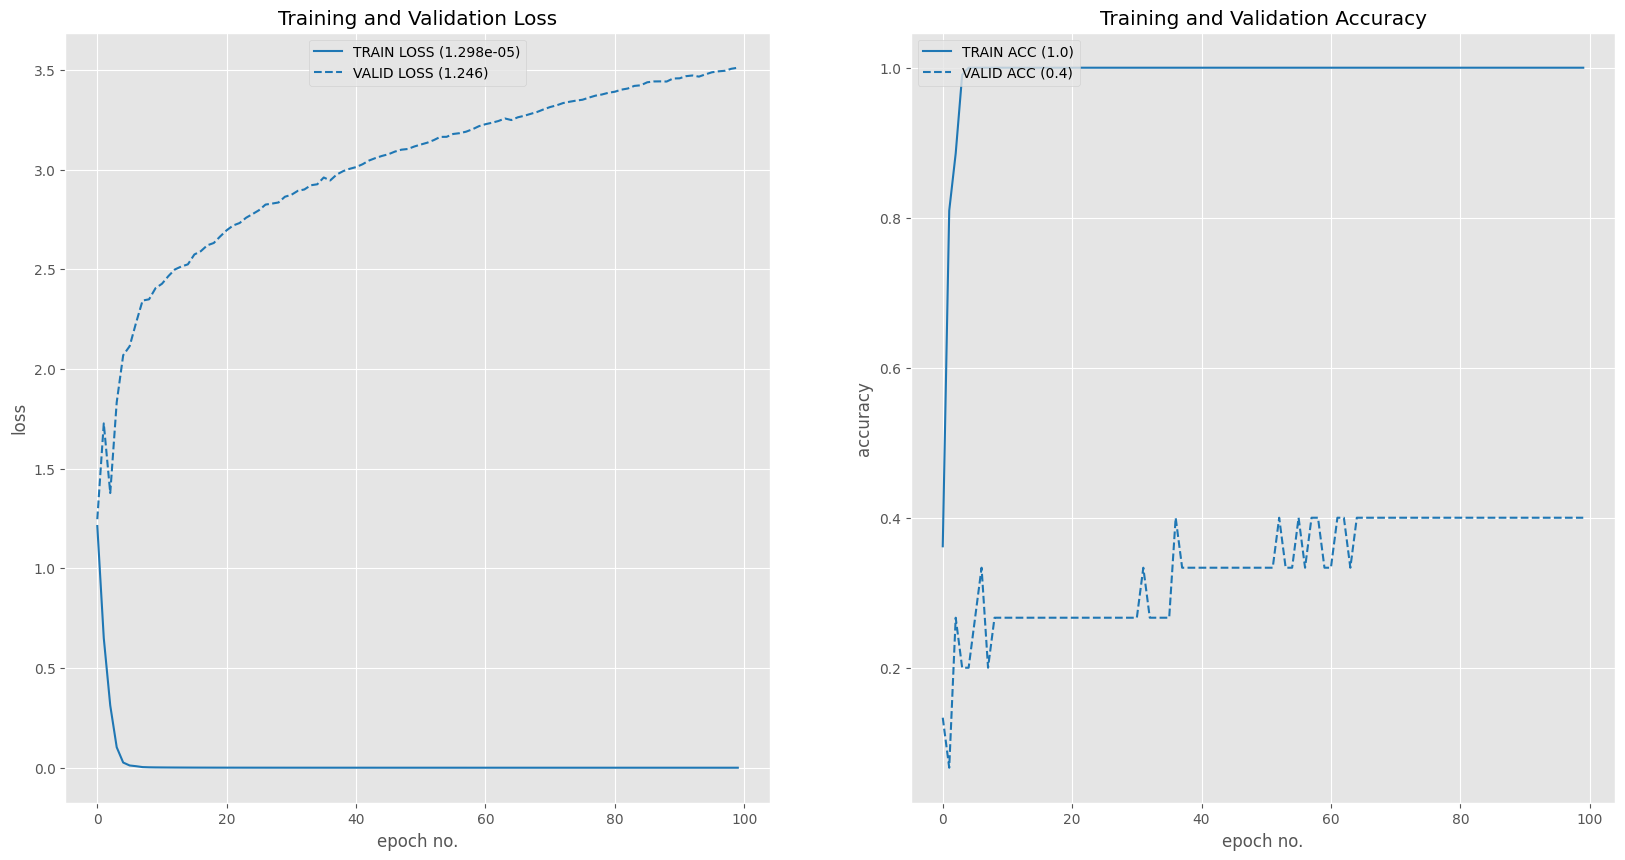

In [38]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# <font style="color:blue">Sample Prediction</font><a name="predictions"></a>


## <font style="color:blue">Make Predictions</font>


In [39]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">Get Predictions on a Batch</font>


In [40]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return

## <font style="color:blue">5.3. Load Model and Run Inference</font>


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


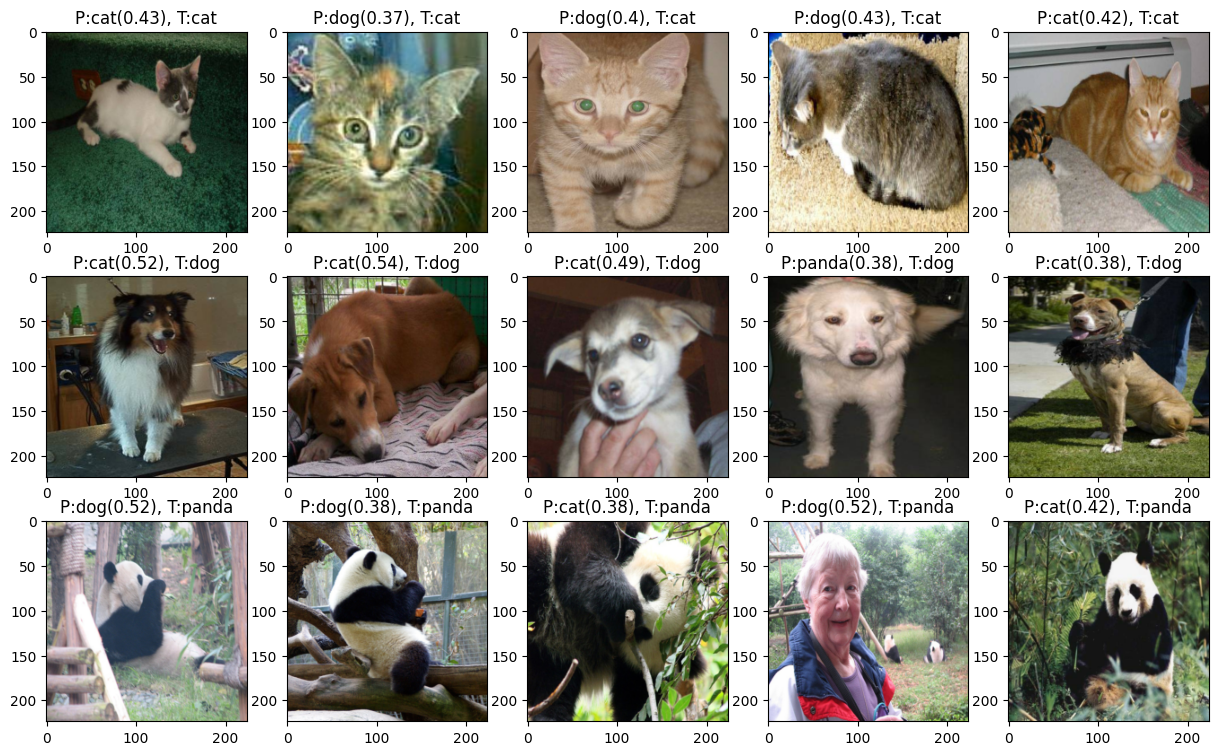

In [41]:
trained_model = MyModel()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)

train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")

mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)

get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

Despite training the network on a very small subset of data, the predictions are not that bad. This means that our model is ready for training.


# <font style="color:blue">Display Mistakes</font><a name="display"></a>


In [42]:
def get_wrong_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for index in range(data_len):
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    mistake_cls = []
    mistake_prob = []
    real_target = []
    real_img = []
    
    for i in range(3):
        count = 0
        for j in range(i * 100, (i+1) * 100):
            if valid_dataset.classes[cls[j]] != valid_dataset.classes[targets[j]]:
                mistake_cls.append(cls[j])
                mistake_prob.append(prob[j])
                real_target.append(targets[j])
                real_img.append(imgs[j])
                count += 1
                if count == 5:
                    break

    for i, target in enumerate(real_target):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(real_img[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[mistake_cls[i]]}({mistake_prob[i]:.2}), T:{valid_dataset.classes[real_target[i]]}")
    plt.show()

    return

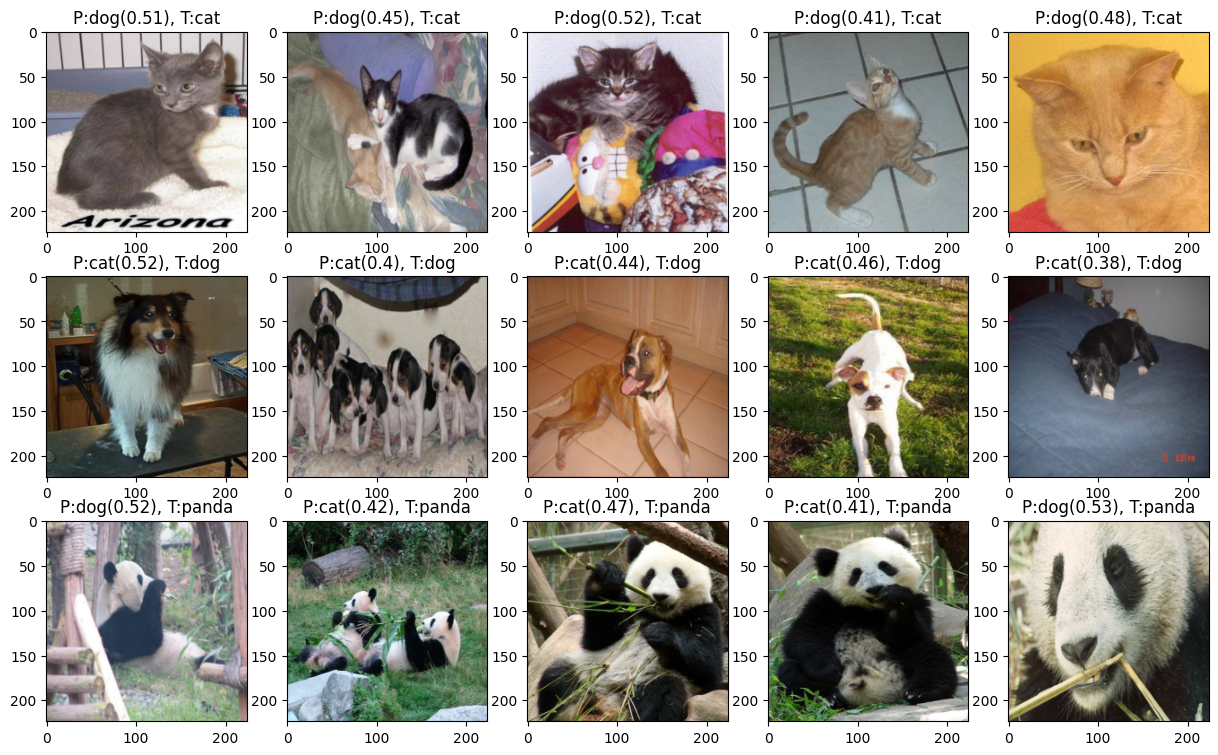

In [43]:
get_wrong_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)